<a href="https://colab.research.google.com/github/edcalderin/DeepLearning_SaturdaysAI/blob/master/6_DeepUnsupervisedLearning/GAN_pr%C3%A1ctica_ejercicio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***GAN***
Reference: https://arxiv.org/pdf/1406.2661.pdf

In [ ]:
!pip install torch torchvision

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image


In [ ]:
import numpy as np
import datetime
import os, sys


In [ ]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline


In [ ]:
MODEL_NAME = 'VanillaGAN_Saturdays.ai'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [ ]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            # Agregar capa de LeakyRelu
            # Agregar capa Linear que pase la imagen de 512 a 256
            # Agregar capa de LeakyRelu
            # Agregar capa Linear que pase la imagen del tamaño actual al que corresponda
            # Agregar capa de Sigmoid
        )
    
    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_


In [ ]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            # Agregar capa Linear que pase la imagen a 128
            # Agregar capa de LeakyRelu
            # Agregar capa Linear que pase la imagen a 256
            # Agregar capa de LeakyRelu
            # Agregar batch nomralization
            # Agregar capa de LeakyRelu
            # Agregar capa Linear que pase la imagen a 512
            # Agregar batch nomralization
            # Agregar capa de LeakyRelu
            # Agregar capa Linear que pase la imagen a 1024
            # Agregar batch nomralization
            # Agregar capa de LeakyRelu
            # Agregar capa Linear que pase la imagen del tamaño actual al que corresponda
            # Agregar capa de Tanh
        )
        
    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [ ]:
n_noise = 100

In [ ]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                # Normalizar con promedio y desviación estándar de 0.5
                                ]
)

In [ ]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

In [ ]:
batch_size = 64

In [ ]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
criterion = nn.BCELoss()
D_opt = ... # Utilizar optimizador Adam con LR 0.0002 y betas=(0.5, 0.999)
G_opt = ... # Utilizar optimizador Adam con LR 0.0002 y betas=(0.5, 0.999)

In [ ]:
max_epoch = 50 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [ ]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [ ]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [ ]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = ... # Calcular
        D_z_loss = ... # Calcular
        D_loss = ... # Calcular D_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1


Epoch: 0/50, Step: 0, D Loss: 1.3756623268127441, G Loss: 0.6990456581115723


KeyboardInterrupt: ignored

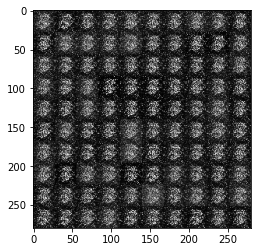

In [ ]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')


In [ ]:
# Saving params.
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')